In [116]:
from sentiment.modeling import *
from sentiment.data_loader import *
from sentiment.training import *
from transformers import BertTokenizer
import pandas as pd
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader
from utils import *
import ast
from clean_text import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def create_data_load(df, tokenizer, max_len, batch_size):
    collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
    ds = NewsDataset(
        news=df.news.to_list(),
        labels = [None]* len(df),
        tokenizer=tokenizer,
        max_len=max_len,
        train=False
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        collate_fn=collator)


def get_pred(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            predictions.extend(preds)
            prediction_probs.extend(probs)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return predictions, prediction_probs



In [188]:
import numpy as np
def buy_sell(df_stock):

    initial_balance = 1000  # initial balance in dollars
    balance = initial_balance
    stocks_owned = 0  # number of stocks owned

    recent_sentiments = []  # store recent sentiments here
    recent_sentiments_limit = 2 # only consider the last one sentiments

    newlist = []
    newlist2 = []
    newlistbuy = []
    newlistsell = []



    buy_price = 0

    # Set a fixed amount to buy/sell
    fixed_amount = 100

    # Define thresholds
    # buy_threshold = 108 / 2
    # sell_threshold = 1000 / 108 /2

    # Loop over the DataFrame
    for index, row in df_stock.iterrows():

        #buy_threshold = row['now'] / 2
        #sell_threshold = 1000 / row['now'] /2
        # Add the sentiment to the list of recent sentiments

        recent_sentiments.append(row['pred'])
        print(recent_sentiments)

        if len(recent_sentiments) > recent_sentiments_limit:
            # If the list is too long, remove the oldest sentiment
            recent_sentiments.pop(0)

        #if row['sentiment'] == "POSITIVE" and balance > buy_threshold:
        if row['pred'] == 1 and balance > 0:
            # Buy stocks when sentiment is positive and balance is above threshold
            buy_price = row['now']
            num_stocks_to_buy = fixed_amount / row['now']
            cost = num_stocks_to_buy * row['now']
            balance -= cost  # deduct the cost from balance
            stocks_owned += num_stocks_to_buy
            print(f"Balance {balance} Buying {num_stocks_to_buy} stocks. Total owned: {stocks_owned}")
            newlistbuy.append(row['date'])

        # Check if all recent sentiments are the same
        if len(set(recent_sentiments)) == 1:
            sentiment = recent_sentiments[0]

            #if sentiment == "NEGATIVE" and stocks_owned > sell_threshold:
            if sentiment == 0 and stocks_owned > 0:
                # Sell stocks when sentiment is negative and owned stocks are above threshold
                num_stocks_to_sell = min(stocks_owned, fixed_amount / row['now'])
                revenue = num_stocks_to_sell * row['now']
                balance += revenue  # add the revenue to balance
                stocks_owned -= num_stocks_to_sell
                print(f"Selling {num_stocks_to_sell} stocks for ${revenue}. Total owned: {stocks_owned}")
                newlistsell.append(row['date'])

            newlist.append(balance + (stocks_owned * row['now']))
            newlist2.append(row['date'])

        # Sell all stocks if the price drops by 5% or more
        if stocks_owned > 0 and row['now'] < 0.95 * buy_price:
            revenue = stocks_owned * row['now']
            balance += revenue
            print(f"Selling all stocks due to 5% price drop for ${revenue}. Total owned: 0")
            stocks_owned = 0
            newlistsell.append(row['date'])

    final_balance = balance + stocks_owned * df_stock.iloc[-1]['now']
    print(f"Final balance: ${final_balance}")
    return_rate = (final_balance - initial_balance) / initial_balance
    print(f"Return rate: {return_rate*100}%")

In [118]:
model_bert = SentimentClassifier(2, "bert-base-uncased", do_fine_tune = True).to(device)
model_bert.load_state_dict(torch.load("sentiment/saved_models/bert-base-with-dropout.bin")) # tried to load different model - 

<All keys matched successfully>

In [3]:
model_finbert = SentimentClassifier(2, "ProsusAI/finbert", do_fine_tune = True).to(device)
model_finbert.load_state_dict(torch.load("sentiment/saved_models/finbert-fine-tune.bin")) # tried to load different model - 

<All keys matched successfully>

In [14]:
tupras_df = pd.read_excel("tuprs_kap_en.xlsx")
tupras_df = tupras_df.dropna(subset=['header', 'date'])
tupras_df.reset_index(drop=True, inplace=True)
tupras_df.drop(columns=['Unnamed: 0'], inplace=True)
tupras_df.head()


,header,date,notification_type
0,Statement of Responsibility (Consolidated),31.07.2023 18:20:16,FR
1,Corporate Governance Principles Compliance Rating,31.07.2023 15:17:15,SDA
2,Transformation Announcement for Exchange Trade...,24.07.2023 16:50:34,NaN
3,Financial Report,31.07.2023 18:20:41,NaN
4,Transformation Announcement for Exchange Trade...,19.07.2023 17:06:50,NaN


In [19]:
tupras_df.columns

Index(['header', 'date', 'notification_type'], dtype='object')

In [5]:
def dateCleaning(datestr):
    date = str(datestr.split(" ")[0])
    try:
        temp = date.split(".")
    except:
        return None
    if len(temp)<3:
        return None
    y= temp[2]
    m= temp[1]
    d = temp[0]
    return y+"-"+m+"-"+d

In [15]:
tupras_df.rename(columns = {"header" : "news"}, inplace = True)
tupras_df['news not cleaned'] = tupras_df['news']

tupras_df['news'] = tupras_df['news'].apply(lambda x: textCleaning(x))
#tupras_df['date'] = tupras_df['date'].apply(lambda x: dateCleaning(x))
tupras_df.dropna(subset=['date'], inplace=True)
tupras_df



,news,date,notification_type,news not cleaned
0,statement responsibility consolidated,31.07.2023 18:20:16,FR,Statement of Responsibility (Consolidated)
1,corporate governance principle compliance rating,31.07.2023 15:17:15,SDA,Corporate Governance Principles Compliance Rating
2,transformation announcement exchange traded eq...,24.07.2023 16:50:34,NaN,Transformation Announcement for Exchange Trade...
3,financial report,31.07.2023 18:20:41,NaN,Financial Report
4,transformation announcement exchange traded eq...,19.07.2023 17:06:50,NaN,Transformation Announcement for Exchange Trade...
...,...,...,...,...
94,notification regarding capital market instrume...,28.11.2022 :52:4122,NaN,Notification Regarding Capital Market Instrume...
95,trade queueincluding intereststop notification,07.12.2022 :50:2822,DKB,Trade Queue(Including Interest)Stop Notification
96,material event disclosure general,28.11.2022 :24:2122,SDA,Material Event Disclosure (General)
97,debt security mutual fund warrant redemption c...,28.11.2022 :31:5522,NaN,"Debt Securities, Mutual Funds and Warrants Red..."


In [7]:
tupras_df.index

RangeIndex(start=0, stop=99, step=1)

In [16]:
MAX_LEN = 512
BATCH_SIZE = 8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(tupras_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_bert, data_loader)



tupras_df['pred'] = y_pred.tolist()
tupras_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
tupras_df['pred new'] = None
for index, row in tupras_df.iterrows():
    
    if row['pred'] == 1 and row['pred_prob'][1] > 0.8:
        tupras_df.at[index ,'pred new']=1
    elif row['pred'] == 0 and row['pred_prob'][0] > 0.8:
        tupras_df.at[index, 'pred new']=0
    else:
        tupras_df.at[index, 'pred new'] = None
        

In [9]:
tupras_df.columns

Index(['news', 'date', 'notification_type', 'news not cleaned', 'pred',
       'pred_prob', 'pred new'],
      dtype='object')

In [17]:
def san_date(datestr):
    try:
        temp = datestr.strip().split()[0].split('.')
        return temp[2] + '-' + temp[1] + '-' + temp[0]
    except:
        return None

In [18]:
tupras_df['date'] = tupras_df['date'].apply(lambda x: san_date(x))

In [19]:
tupras_df

,news,date,notification_type,news not cleaned,pred,pred_prob,pred new
0,statement responsibility consolidated,2023-07-31,FR,Statement of Responsibility (Consolidated),1,"[0.1804053634405136, 0.8195945620536804]",1
1,corporate governance principle compliance rating,2023-07-31,SDA,Corporate Governance Principles Compliance Rating,1,"[0.1804053634405136, 0.8195945620536804]",1
2,transformation announcement exchange traded eq...,2023-07-24,NaN,Transformation Announcement for Exchange Trade...,1,"[0.1804053634405136, 0.8195945620536804]",1
3,financial report,2023-07-31,NaN,Financial Report,1,"[0.1804053634405136, 0.8195945620536804]",1
4,transformation announcement exchange traded eq...,2023-07-19,NaN,Transformation Announcement for Exchange Trade...,1,"[0.1804053634405136, 0.8195945620536804]",1
...,...,...,...,...,...,...,...
94,notification regarding capital market instrume...,2022-11-28,NaN,Notification Regarding Capital Market Instrume...,1,"[0.1804053634405136, 0.8195945620536804]",1
95,trade queueincluding intereststop notification,2022-12-07,DKB,Trade Queue(Including Interest)Stop Notification,0,"[0.4220062792301178, 0.5779937505722046]",None
96,material event disclosure general,2022-11-28,SDA,Material Event Disclosure (General),0,"[0.4220062792301178, 0.5779937505722046]",None
97,debt security mutual fund warrant redemption c...,2022-11-28,NaN,"Debt Securities, Mutual Funds and Warrants Red...",1,"[0.1804053634405136, 0.8195945620536804]",1


In [20]:
import yfinance as yf
import matplotlib.pyplot as plt 
temp = yf.Ticker("TUPRS.IS")
yf_df = temp.history(start="2022-12-01")
yf_df = yf_df.Close
print(yf_df)

Date
2022-12-01 00:00:00+03:00     64.361748
2022-12-02 00:00:00+03:00     63.844196
2022-12-05 00:00:00+03:00     62.795830
2022-12-06 00:00:00+03:00     64.016716
2022-12-07 00:00:00+03:00     61.044132
                                ...    
2023-08-15 00:00:00+03:00    114.400002
2023-08-16 00:00:00+03:00    119.199997
2023-08-17 00:00:00+03:00    123.000000
2023-08-18 00:00:00+03:00    127.000000
2023-08-21 00:00:00+03:00    131.300003
Name: Close, Length: 178, dtype: float64


In [21]:
tupras_df.to_excel(f"tupras_sentimented.xlsx")

In [22]:
def handle_dfs(stock_code, df):
    temp = yf.Ticker(stock_code)
    yf_df = temp.history(start="2022-12-01")
    yf_df = yf_df.Close
    yf_df.dropna(inplace=True)
    
    reset_df = yf_df.reset_index()
    reset_df['date'] = reset_df['Date'].astype(str).apply(lambda x: x.split(' ')[0])
    merge_df = pd.merge(df, reset_df, on='date')
    
    print(merge_df.columns)
    bad_new_prices = merge_df[merge_df['pred'] == 0]['Close']
    bad_new_dates = merge_df[merge_df['pred'] == 0]['Date']

    good_new_prices = merge_df[merge_df['pred'] == 1]['Close']
    good_new_dates = merge_df[merge_df['pred'] == 1]['Date']
    print(merge_df)
   
    
    return bad_new_prices, bad_new_dates, good_new_prices, good_new_dates, reset_df

47
35
35


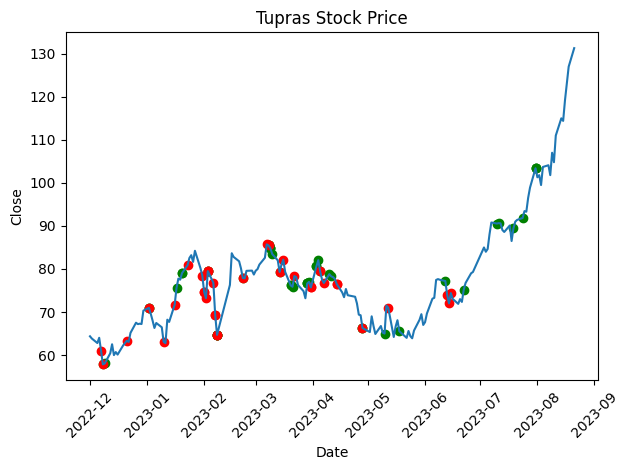

In [24]:


plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Tupras Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()

print(len(pos_date))
print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

In [95]:
from datetime import datetime, timedelta

def measure_performance(neg_dates, pos_dates, yahoo_df):
    neg_counter = 0
    for date_entity in neg_dates:
        date = date_entity.date()
        if date in yahoo_df.index:
            for i in range(1,3):
                time_delta = timedelta(days=i)
                if date + time_delta in yahoo_df.index:
                    if (yahoo_df.loc[date + time_delta] < yahoo_df.loc[date]* 0.99):
                        neg_counter += 1
                    break
    pos_counter = 0
    for date_entity in pos_dates:
        date = date_entity.date()
        if date in yahoo_df.index:
            for i in range(1,3):
                time_delta = timedelta(days=i)
                if date - time_delta in yahoo_df.index:
                    if (yahoo_df.loc[date - time_delta] > yahoo_df.loc[date]* 1.01):
                        pos_counter += 1
                    break
    
    return neg_counter/len(neg_dates), pos_counter/len(pos_dates)
                        

In [96]:
temp = yf.Ticker("TUPRS.IS")
yahoo_df = temp.history(start="2023-01-01")
yahoo_df.index = yahoo_df.index.date
yahoo_df = yahoo_df.Close
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("TUPRS.IS", tupras_df)
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print(x, y)

Index(['news', 'date', 'notification_type', 'news not cleaned', 'pred',
       'pred_prob', 'pred new', 'before', 'after', 'now', 'label', 'Date',
       'Close'],
      dtype='object')
                                                 news        date  \
0      trade queueincluding intereststop notification  2022-12-07   
1                         acquisition financial asset  2022-12-08   
2                       trade queue stop notification  2022-12-08   
3   transformation announcement exchange traded eq...  2022-12-09   
4                   material event disclosure general  2022-12-21   
..                                                ...         ...   
77  transformation announcement exchange traded eq...  2023-07-19   
78  transformation announcement exchange traded eq...  2023-07-24   
79   corporate governance principle compliance rating  2023-07-31   
80                                   financial report  2023-07-31   
81              statement responsibility consolidated  

In [109]:
def add_prices(yahoo_df, kap_df):
    kap_df['before'] =None
    kap_df['after'] = None
    kap_df['now'] = None
    for index, row  in kap_df.iterrows(): 
        date_str = row["date"]
        try:
            date = datetime.strptime(date_str, "%Y-%m-%d").date()
        except:
            continue
        if date in yahoo_df.index.unique():
           
            kap_df.loc[index, 'now'] = yahoo_df.loc[date]
            for i in range(1,4):
                time_delta = timedelta(days=i)
                if date + time_delta in yahoo_df.index.unique() :
                    kap_df.loc[index, "after"] = yahoo_df.loc[date + time_delta]
                    break
            for i in range(1,4):
                time_delta = timedelta(days=i)
                if date - time_delta in yahoo_df.index.unique():
                    kap_df.loc[index, "before"] = yahoo_df.loc[date - time_delta]
                    break
            

In [110]:

add_prices(yahoo_df, tupras_df)
tupras_df.to_excel("tupras_prices.xlsx")

In [111]:
tupras_df.sort_values(by='date', ascending=True, inplace=True)
tupras_df['label'] = None
for index, row in tupras_df.iterrows():
    if(row['now']==None or row['after']==None):
        continue
    if row['now'] * 1.01 > row['after']:
        row['label'] = 1
    elif row['now'] * 0.99 < row['after']:
        row['label'] = 0

In [112]:
tupras_df.to_excel("tupras_kap_labeled.xlsx")

In [206]:
def label_data(df):
    df.sort_values(by=['date'], ascending = True, inplace=True)
    df['label'] = None
    for index, row in df.iterrows():
        if row['after'] >  row['now'] * 1.01:
            df.at[index, 'label'] = 1
        elif row['after'] < row['now'] * 0.99:
            df.at[index, 'label'] = 0
        else:
            df.at[index, 'label'] = 2 # neutral



In [262]:
def get_df(filename):
    df = pd.read_excel(filename)
    df.rename(columns = {df.columns[1]:'header'}, inplace = True)
    df.rename(columns = {df.columns[2]:'date'}, inplace = True)
    df = df.dropna(subset = ['header', 'date'])
    df.reset_index(drop=True, inplace=True)
    df.rename(columns = {'header':'news'}, inplace = True)
    df['date'] = df['date'].apply(lambda x: x.strip())
    df['news'] = df['news'].apply(lambda x: textCleaning(x))
    df['date'] = df['date'].apply(lambda x: x.split(' ')[0])
    df.drop(columns=['Unnamed: 0'], inplace=True)
    for index, row in df.iterrows():
        temp = row['date'].split('.')
        temp.reverse()
        date_str =  '-'.join(temp)
        df.at[index, 'date'] = datetime.strptime(date_str, '%Y-%m-%d').date()

    return df


In [173]:
import yfinance as yf
def get_yahoo_df(stock_code):
    temp = yf.Ticker("TUPRS.IS")
    yahoo_df = temp.history(start="2022-10-01")
    yahoo_df.index = yahoo_df.index.date
    yahoo_df = yahoo_df.Close
    return yahoo_df
    
    

In [238]:
def match_before_after(yf_df, df):
    df['now']= None
    df['before'] = None
    df['after'] = None
    for index, row in df.iterrows():
        try:
            df.loc[index, 'now'] = yf_df.loc[row['date']]
            
            try:
                df.loc[index, 'after'] = yf_df.loc[row['date']+timedelta(days=1)]
            except:
                try:
                    df.loc[index, 'after'] = yf_df.loc[row['date']+timedelta(days=3)]
                except:
                    df.loc[index, 'after'] = None
            try:
                df.loc[index, 'before'] = yf_df.loc[row['date']-timedelta(days=1)]
            except:
                try:
                    df.loc[index, 'before'] = yf_df.loc[row['date']-timedelta(days=3)]
                except:
                    df.loc[index, 'before'] = None
    
        except:
            continue


In [ ]:
thyao_price_df = get_yahoo_df("THYAO.IS")
thyao_df = get_df("thyao_kap.xlsx")
match_before_after(thyao_price_df, thyao_df)
thyao_df.dropna(subset = ['now', 'before', 'after'], how = 'any', inplace = True)
label_data(thyao_df)
MAX_LEN = 512
BATCH_SIZE = 8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(thyao_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_bert, data_loader)
thyao_df['pred'] = y_pred.tolist()
thyao_df.to_excel("kap_labeled/thyao_kap_labeled.xlsx")



In [205]:
thyao_df.sort_values(by='date', ascending= True, inplace=True)
buy_sell(thyao_df)

[0]
[0, 1]
Balance 900.0 Buying 2.0121581191037583 stocks. Total owned: 2.0121581191037583
[0, 1, 1]
Balance 800.0 Buying 2.0121581191037583 stocks. Total owned: 4.024316238207517
[1, 1, 0]
[1, 0, 0]
Selling 1.9077297023902657 stocks for $100.0. Total owned: 2.116586535817251
[0, 0, 0]
Selling 1.9077297023902657 stocks for $100.0. Total owned: 0.20885683342698513
[0, 0, 1]
Balance 900.0 Buying 1.9077297023902657 stocks. Total owned: 2.116586535817251
[0, 1, 1]
Balance 800.0 Buying 1.9077297023902657 stocks. Total owned: 4.024316238207517
[1, 1, 0]
[1, 0, 1]
Balance 700.0 Buying 1.7598159733455119 stocks. Total owned: 5.784132211553029
[0, 1, 0]
[1, 0, 1]
Balance 600.0 Buying 1.7705667192704408 stocks. Total owned: 7.55469893082347
[0, 1, 1]
Balance 500.0 Buying 1.6005802885079186 stocks. Total owned: 9.155279219331389
[1, 1, 0]
[1, 0, 0]
Selling 1.7287295779046752 stocks for $100.0. Total owned: 7.426549641426714
Selling all stocks due to 5% price drop for $429.59579892351593. Total ow

In [ ]:
hektas_price_df = get_yahoo_df("HEKTS.IS")
hektas_df = get_df("thyao_kap.xlsx")
match_before_after(hektas_price_df, thyao_df)
hektas_df.dropna(subset = ['now', 'before', 'after'], how = 'any', inplace = True)
label_data(hektas_df)
MAX_LEN = 512
BATCH_SIZE = 8
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(thyao_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_bert, data_loader)
thyao_df['pred'] = y_pred.tolist()
thyao_df.to_excel("kap_labeled/thyao_kap_labeled.xlsx")
thyao_df.sort_values(by='date', ascending= True, inplace=True)
buy_sell(thyao_df)



In [267]:

def do_all(stock_code):
    print("------------------{}------------------".format(stock_code))
    stock_price_df = get_yahoo_df(f"{stock_code}.IS".upper())
    stock_df = get_df(f"kap_en/{stock_code}_kap.xlsx")
    match_before_after(stock_price_df, stock_df)
    stock_df.dropna(subset = ['now', 'before', 'after'], how = 'any', inplace = True)
    label_data(stock_df)
    MAX_LEN = 512
    BATCH_SIZE = 8
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    data_loader = create_data_load(stock_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
    y_pred, y_pred_probs = get_pred(model_bert, data_loader)
    stock_df['pred'] = y_pred.tolist()
    stock_df.to_excel(f"kap_labeled/{stock}_kap_labeled.xlsx")
    stock_df.sort_values(by='date', ascending= True, inplace=True)
    buy_sell(stock_df)


In [269]:
stock_codes = ["akbnk","alark","asels", "bimas", "froto", "isbir", "kchol", 'kozal',"odas", "pgsus", "sasa",
        "tuprs", "toaso", "tcell", "sise", "eregl", "ekgyo", "cment", "arclk"]
for stock in stock_codes:
    do_all(stock)

------------------akbnk------------------
                                 Open        High         Low       Close  \
Date                                                                        
2022-10-03 00:00:00+03:00   39.267300   42.266426   39.227491   42.266426   
2022-10-04 00:00:00+03:00   43.394417   45.278823   43.235171   44.522404   
2022-10-05 00:00:00+03:00   44.522403   45.703476   43.659824   45.053223   
2022-10-06 00:00:00+03:00   45.915800   46.911086   45.836179   46.048504   
2022-10-07 00:00:00+03:00   46.048505   46.473162   45.637121   45.968884   
...                               ...         ...         ...         ...   
2023-08-17 00:00:00+03:00  119.199997  123.300003  118.199997  123.000000   
2023-08-18 00:00:00+03:00  125.400002  133.000000  124.500000  127.000000   
2023-08-21 00:00:00+03:00  127.400002  139.699997  127.400002  139.699997   
2023-08-22 00:00:00+03:00  140.600006  149.500000  139.000000  139.000000   
2023-08-23 00:00:00+03:00  139.800

In [309]:
stock_codes = ["akbnk","alark","asels", "bimas", "froto", "isbir", "kchol", 'kozal',"odas", "pgsus", "sasa",
    "tuprs", "toaso", "tcell", "sise", "eregl", "ekgyo", "cment", "arclk"]
sentiments = [ "sentiment_s", "sentiment_y","sentiment_esit","sentiment_fu", "pred"]

new_df = pd.DataFrame(columns=["Stocks", "correlation"])
new_df.index = new_df["Stocks"]

df = pd.read_excel("kap2.xlsx")


for stock_code in stock_codes:
    temp_df = df[df["Stocks"] == stock_code.upper()]
    temp_df.sort_values(by="date", inplace=True, ascending=True)
    temp_len = len(temp_df)
    correct_answers = 0
    for index, row in temp_df.iterrows():
        increase = int((row["after"] - row["now"] > 0) == 1)
        pred = int(row["sentiment_s"])
        if row["label"] == pred:
            correct_answers += 1
    print(f"{stock_code} correlation" , correct_answers / temp_len)
    new_df.loc[stock_code, "correlation"] = correct_answers / temp_len

print(new_df)
new_df.to_excel("correlation_sena.xlsx")
    


    
    
        






    



akbnk correlation 0.291005291005291
alark correlation 0.23529411764705882
asels correlation 0.25396825396825395
bimas correlation 0.1797752808988764
froto correlation 0.2222222222222222
isbir correlation 0.20512820512820512
kchol correlation 0.3135593220338983
kozal correlation 0.23255813953488372
odas correlation 0.27586206896551724
pgsus correlation 0.2857142857142857
sasa correlation 0.27472527472527475
tuprs correlation 0.2828282828282828
toaso correlation 0.2676056338028169
tcell correlation 0.2602739726027397
sise correlation 0.2808219178082192
eregl correlation 0.22935779816513763
ekgyo correlation 0.27896995708154504
cment correlation 0.10204081632653061
arclk correlation 0.2727272727272727
       Stocks correlation
Stocks                   
akbnk     NaN    0.291005
alark     NaN    0.235294
asels     NaN    0.253968
bimas     NaN    0.179775
froto     NaN    0.222222
isbir     NaN    0.205128
kchol     NaN    0.313559
kozal     NaN    0.232558
odas      NaN    0.275862
pgsus 

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_66025/4087041980.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.sort_values(by="date", inplace=True, ascending=True)
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_66025/4087041980.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.sort_values(by="date", inplace=True, ascending=True)
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_66025/4087041980.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-